In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [2]:
data_df = pd.read_pickle('cleaned_features.pkl')
y_label = pd.read_pickle('label.pkl')
feature_columns = data_df.columns

In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
scaling = preprocessing.StandardScaler()
data_scaled = scaling.fit_transform(data_df[feature_columns])
scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test = train_test_split(data_scaled,y_label,test_size=0.4, random_state=40)

In [5]:
sm = SMOTE(random_state = 42)
X_res,y_res = sm.fit_sample(scaled_X_train,scaled_y_train)

### Grid Search for RandomForest

In [6]:
RF = RandomForestClassifier()

In [ ]:
tuned_parameters = [{'n_estimators': [20,40,80],
                    'max_features':['sqrt','log2']
                    }]
scores = ['roc_auc']

for score in scores:
    print "# Tuning hyper-parameters for %s" % score
    print 

    clf = GridSearchCV(RF, tuned_parameters, cv=5,
                       scoring = score,verbose=True)
    clf.fit(X_res, y_res)

    print "Best parameters set found on development set:",clf.best_params_
    print
    print "Grid scores on development set:"
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print "%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params)
    print

    print "Detailed classification report:"
    print 
    print "The model is trained on the full development set."
    print "The scores are computed on the full evaluation set."
    print 
    y_true, y_pred,y_prob = y_test, clf.predict(X_test),clf.predict_proba(X_test)
    print classification_report(y_true, y_pred)
    print


In [9]:
y_true, y_pred,y_prob = scaled_y_test, clf.predict(scaled_X_test),clf.predict_proba(scaled_X_test)
print classification_report(y_true, y_pred)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    725949
          1       1.00      0.97      0.99     76882

avg / total       1.00      1.00      1.00    802831



In [16]:
def RF_feature_rank(model,topk=15):
    # get feature names
    feature_names = data_df.columns
    # get feature average score
    feature_mean_score = model.best_estimator_.feature_importances_
    # get feature score (list of array)
    scores = [tree.feature_importances_ for tree in model.best_estimator_.estimators_]
    # change to a numpy array 
    scores_array = np.array(scores)
    # calculate standard deviation for each feature (column direction)
    score_std = np.std(scores_array, axis=0)
    
    # create a dataframe
    feature_df = pd.DataFrame({'feature_names':feature_names,
                               'feature_score':feature_mean_score,
                               'score_std':score_std})
    # get most siginificant features 
    top_features = feature_df.sort_values('feature_score').iloc[-topk:]
    # generate bar plot
    fig,ax=plt.subplots()
    ax = top_features['feature_score'].plot.barh(xerr=top_features['score_std'],title='feature_importances')
    ax.set_xlabel('feature score')
    ax.set_ylabel('features')
    ax.set_yticklabels(top_features['feature_names'])

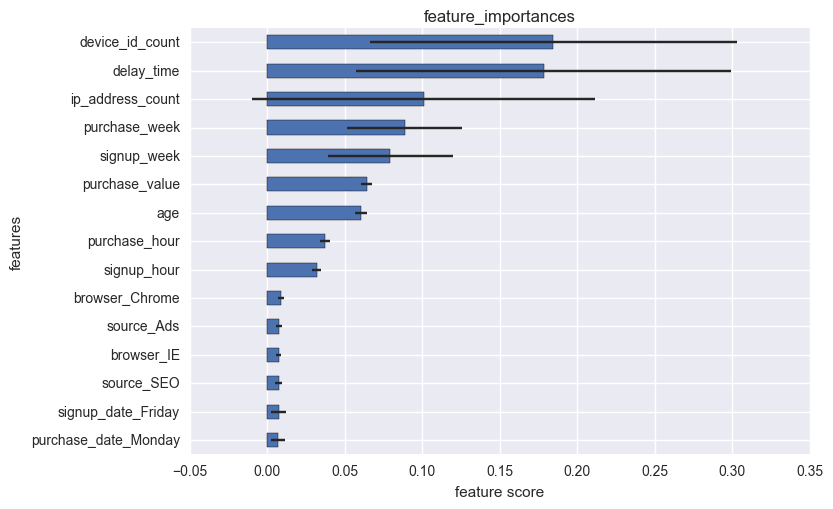

In [17]:
RF_feature_rank(clf)

In [18]:
def plot_confusion_matrix(ytest,ypredict):
    cm =confusion_matrix(ytest, ypredict)
    row_sums = cm.astype('float').sum(axis=1,keepdims=True)
    RF_cm = cm / row_sums
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(RF_cm,annot=True)
    ax.set(xlabel='Predicted Label',ylabel='True Label')

In [19]:
def plot_binary_ROC(ytest,yprob):
    fpr,tpr,_= roc_curve(ytest,yprob)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve(area = %0.2f)' %roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
    plt.xlim([-0.05,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    

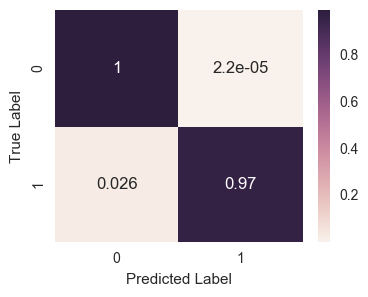

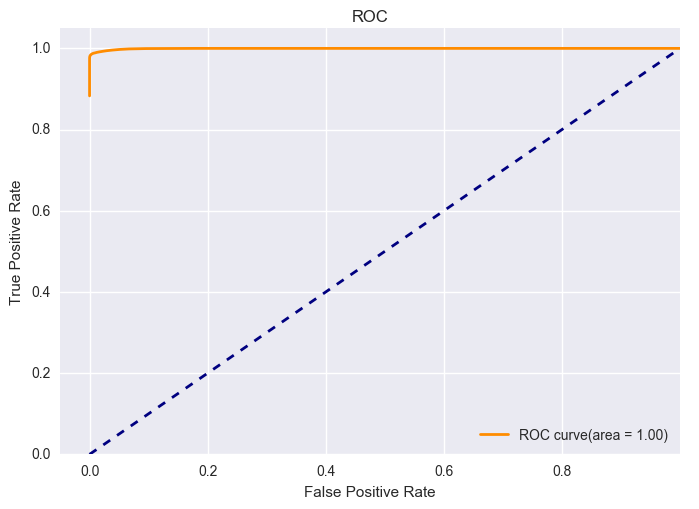

In [21]:
plot_confusion_matrix(y_true,y_pred)
plot_binary_ROC(y_true,y_prob[:,1])